In [77]:
import geopandas as gpd
from shapely.geometry import Polygon
# Get barcode coordinates
#first_barcode_pxl_row, first_barcode_pxl_col, last_barcode_pxl_row, last_barcode_pxl_col = get_barcode_coordinates(df, one_micron)
geojson_file = '../data/processed/dataframe_ground_truth.geojson'

# Read GeoJSON file into a GeoDataFrame
gdf = gpd.read_file(geojson_file)

geometry = gdf[gdf['path_class'] == 'roi_cropped']['geometry'].iloc[0]

# Access exterior coordinates of the polygon
coordinates = geometry.exterior.coords.xy

# Assign coordinates to variables
first_barcode_pxl_row = int(min((coordinates[1])))  # Y-coordinate of the first point
first_barcode_pxl_col = int(min(coordinates[0]))# X-coordinate of the first point
last_barcode_pxl_row = int(max(coordinates[1]))  # Y-coordinate of the last point
last_barcode_pxl_col = int(max(coordinates[0]))  # X-coordinate of the last point

print(first_barcode_pxl_row, first_barcode_pxl_col,last_barcode_pxl_row,last_barcode_pxl_col)


37928 30713 41044 33865


In [78]:
import sys
sys.path.append('../utils')
import os

# Importing importlib for module reloading
import importlib
import image_cropp_utils

# Reloading the module
importlib.reload(image_cropp_utils)

from image_cropp_utils import read_image, crop_image, save_image_as_btf

# Read the image
dir_base = '../data/raw/p5/'
filename = 'Visium_HD_Human_Colon_Cancer_P5_tissue_image.btf'
img = read_image(dir_base + filename)

# Crop the image using the calculated coordinates
cropped_img = crop_image(img, first_barcode_pxl_row, first_barcode_pxl_col, last_barcode_pxl_row, last_barcode_pxl_col)

print(cropped_img.shape)

output_filename = 'p5_cropped_image_overlap_comparison.btf'
output_dir = '../data/processed'
output_path = os.path.join(output_dir, output_filename)
save_image_as_btf(cropped_img, output_path)

(3116, 3152, 3)
Cropped image saved as ../data/processed/p5_cropped_image_overlap_comparison.btf


In [79]:
import sys
sys.path.append('../utils')

# Importing importlib for module reloading
import importlib
import image_segmentation, geodataframe_creation
import matplotlib.pyplot as plt

# Reloading the module
importlib.reload(image_segmentation)

from skimage.io import imread
from image_segmentation import segment_image
from geodataframe_creation import create_geodataframe
from shapely.geometry import Polygon, box

# Assuming you have loaded 'cropped_img' using imread or some other method
#cropped_img = read your btf from previous step

# Perform image segmentation
polys = segment_image(cropped_img)

# Create GeoDataFrame from segmented polygons
gdf = create_geodataframe(polys)

# Adjusting the coordinates in the filtered GeoDataFrame using .loc to avoid SettingWithCopyWarning
def adjust_polygon(polygon, x_offset, y_offset):
    new_coords = [(float(x + x_offset), float(y +
                                               y_offset)) for x, y in polygon.exterior.coords]
    return Polygon(new_coords)
gdf.loc[:, 'geometry'] = gdf['geometry'].apply(lambda poly: adjust_polygon(poly, first_barcode_pxl_col, first_barcode_pxl_row))

geojson_file = '../data/processed/dataframe_ground_truth.geojson'
gdf_file = gpd.read_file(geojson_file)
geometry = gdf_file[gdf_file['path_class'] == 'new_roi']['geometry'].iloc[0]
gdf_filtered = gdf[gdf['geometry'].apply(lambda poly: poly.intersects(geometry))]
gdf_filtered.to_file('../data/processed/dataframe_stardist_overlap_comparison.geojson', driver='GeoJSON')

# Now 'gdf' contains the GeoDataFrame with polygons and IDs
print(gdf_filtered.head())


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
effective: block_size=(1008, 1008, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


100%|██████████| 25/25 [02:21<00:00,  5.67s/it]


                                               geometry       id
1590  POLYGON ((32962.222 38480.000, 32961.906 38482...  ID_1591
1591  POLYGON ((33056.947 38598.000, 33056.915 38599...  ID_1592
1594  POLYGON ((32879.516 38500.000, 32878.213 38503...  ID_1595
1595  POLYGON ((32941.069 38336.000, 32941.535 38337...  ID_1596
1596  POLYGON ((32960.061 38414.000, 32960.278 38415...  ID_1597


<Axes: >

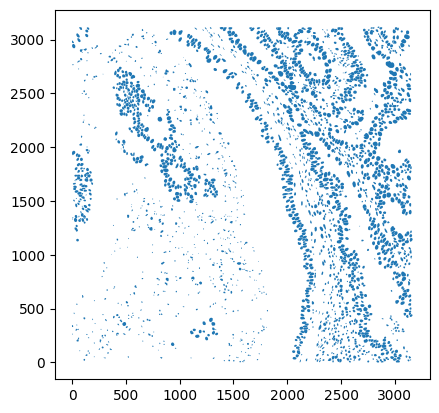

In [80]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import MultiPoint, Polygon, box

geojson_file_cellvit = '../data/processed/cells.geojson'
df = gpd.read_file(geojson_file_cellvit)
df.crs = None
df.plot()

In [81]:
gdf_exploded=df.explode()

2129992116.py (1): Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.


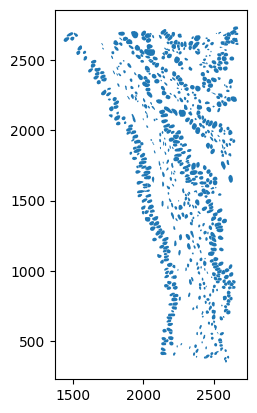

                                         id  objectType  \
0 221  d25c8eae-9ee0-4255-babf-05dc87916bf1  annotation   
  227  d25c8eae-9ee0-4255-babf-05dc87916bf1  annotation   
  229  d25c8eae-9ee0-4255-babf-05dc87916bf1  annotation   
  230  d25c8eae-9ee0-4255-babf-05dc87916bf1  annotation   
  232  d25c8eae-9ee0-4255-babf-05dc87916bf1  annotation   

                                     classification  \
0 221  {'name': 'Neoplastic', 'color': [255, 0, 0]}   
  227  {'name': 'Neoplastic', 'color': [255, 0, 0]}   
  229  {'name': 'Neoplastic', 'color': [255, 0, 0]}   
  230  {'name': 'Neoplastic', 'color': [255, 0, 0]}   
  232  {'name': 'Neoplastic', 'color': [255, 0, 0]}   

                                                geometry  
0 221  POLYGON ((2585.000 346.000, 2583.000 348.000, ...  
  227  POLYGON ((2577.000 362.000, 2576.000 363.000, ...  
  229  POLYGON ((2439.000 372.000, 2438.000 373.000, ...  
  230  POLYGON ((2603.000 374.000, 2595.000 382.000, ...  
  232  POLYGON ((24

In [82]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Filter df to keep only the geometries that intersect with any geometry in gdf3
intersections = gdf_exploded[gdf_exploded.geometry.apply(lambda geom: gdf3.geometry.intersects(geom).any())]

# Save the filtered GeoDataFrame to a new GeoJSON file
intersections.to_file('../data/processed/dataframe_cellvit_overlap_comparison.geojson', driver='GeoJSON')

# Plot the filtered GeoDataFrame
intersections.plot()
plt.show()

# Display the first few rows of the filtered GeoDataFrame
print(intersections.head())
intersections.to_file('../data/processed/dataframe_cellvit_overlap_comparison.geojson', driver='GeoJSON')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


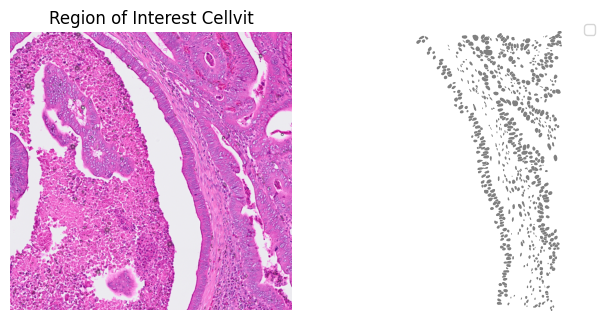

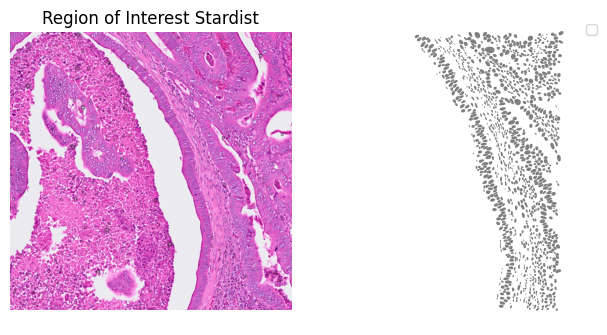

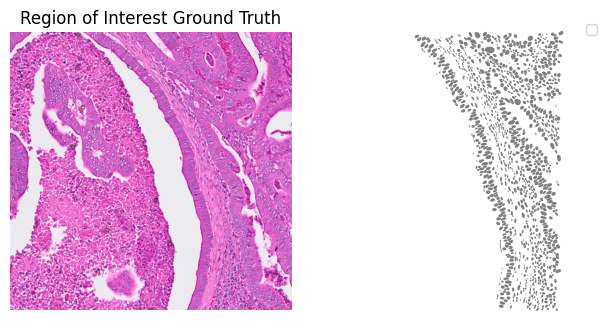

In [83]:
import importlib
import image_plot_utils

# Reloading the module
importlib.reload(image_plot_utils)

from skimage.io import imread
from image_plot_utils import plot_mask_and_save_image
from matplotlib.colors import ListedColormap

cmap=ListedColormap(['grey'])
plot_mask_and_save_image(title="Region of Interest Cellvit",
                         gdf=intersections,
                         cmap=cmap,
                         img=cropped_img,
                         output_name="../data/processed/p5_image_mask_cellvit.ROI1.tif")

cmap=ListedColormap(['grey'])
gdf = gpd.read_file('../data/processed/dataframe_stardist_overlap_comparison.geojson')
gdf.crs = None
plot_mask_and_save_image(title="Region of Interest Stardist",
                         gdf=gdf,
                         cmap=cmap,
                         img=cropped_img,
                         output_name="../data/processed/p5_image_mask_stardist.ROI1.tif")


file_path = '../data/processed/updated_dataframe_ground_truth_overlap_comparison_intersect.geojson'
gdf3 = gpd.read_file(file_path)
gdf3.crs = gdf.crs

plot_mask_and_save_image(title="Region of Interest Ground Truth",
                         gdf=gdf_filtered,
                         cmap=cmap,
                         img=cropped_img,
                         output_name="../data/processed/p5_image_mask_Chang.ROI1.tif")


interactiveshell.py (3466): The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.


           id                                           geometry  index_right  \
2     ID_1595  POLYGON ((2166.516 572.000, 2165.213 575.026, ...          115   
26    ID_1637  POLYGON ((2207.219 558.000, 2206.805 560.547, ...          115   
29    ID_1643  POLYGON ((2197.749 584.000, 2194.436 587.667, ...          115   
140   ID_1885  POLYGON ((2179.733 552.000, 2179.932 553.976, ...          115   
2     ID_1595  POLYGON ((2166.516 572.000, 2165.213 575.026, ...          114   
...       ...                                                ...          ...   
1210  ID_6978  POLYGON ((2601.423 2680.000, 2603.088 2683.399...           52   
1217  ID_7036  POLYGON ((2582.975 2694.000, 2582.314 2698.041...           52   
1211  ID_6990  POLYGON ((2522.250 2664.000, 2522.247 2664.845...          906   
1212  ID_6998  POLYGON ((2512.767 2554.000, 2512.044 2556.396...          911   
1219  ID_7051  POLYGON ((2524.573 2534.000, 2525.303 2537.840...          911   

      path_class  
2       

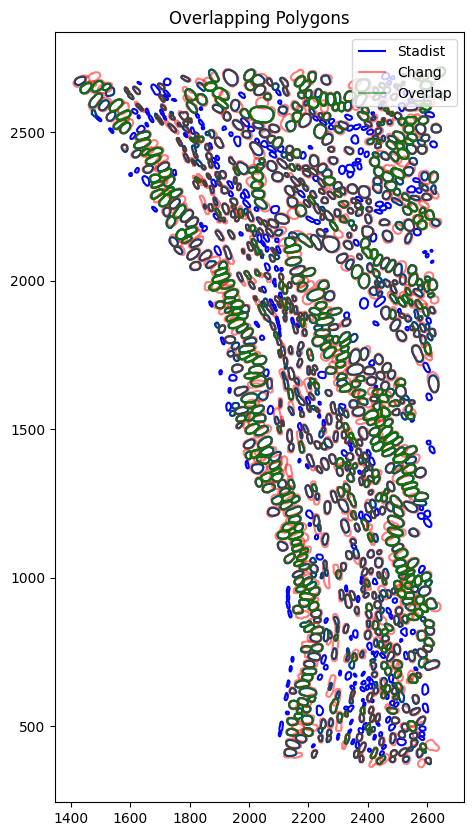

In [84]:
import geopandas as gpd
import matplotlib.pyplot as plt

# File paths to the GeoJSON files
file_path1 = '../data/processed/dataframe_stardist_overlap_comparison.geojson'
file_path2 = '../data/processed/updated_dataframe_ground_truth_overlap_comparison_intersect.geojson'

# Read the GeoJSON files into GeoDataFrames
gdf1 = gpd.read_file(file_path1)
gdf2 = gpd.read_file(file_path2)


gdf1.crs = None
def adjust_polygon(polygon, x_offset, y_offset):
    new_coords = [(float(x - x_offset), float(y - y_offset)) for x, y in polygon.exterior.coords]
    return Polygon(new_coords)

# Adjusting the coordinates in the filtered GeoDataFrame using .loc to avoid SettingWithCopyWarning
gdf1.loc[:, 'geometry'] = gdf1['geometry'].apply(lambda poly: adjust_polygon(poly, first_barcode_pxl_col, first_barcode_pxl_row))



# Ensure both GeoDataFrames have the same CRS
gdf2.crs = None
gdf1.crs = None

# Perform a spatial join to find overlapping polygons
# 'inner' join will keep only overlapping polygons
overlap_gdf_stardist = gpd.sjoin(gdf1, gdf2, how='inner', op='intersects')

# Print the resulting overlapping polygons
print(overlap_gdf_stardist)

# Optionally, plot the overlapping polygons
fig, ax = plt.subplots(figsize=(10, 10))
gdf1.boundary.plot(ax=ax, color='blue', label='Stadist')
gdf2.boundary.plot(ax=ax, color='red', alpha= 0.5,label='Chang')
overlap_gdf_stardist.boundary.plot(ax=ax, color='green', alpha= 0.5, label='Overlap')
ax.set_title('Overlapping Polygons')
ax.legend()
plt.show()

interactiveshell.py (3466): The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.


     level_0  level_1                                    id  objectType  \
0          0      221  d25c8eae-9ee0-4255-babf-05dc87916bf1  annotation   
1          0      227  d25c8eae-9ee0-4255-babf-05dc87916bf1  annotation   
2          0      229  d25c8eae-9ee0-4255-babf-05dc87916bf1  annotation   
5          0      233  d25c8eae-9ee0-4255-babf-05dc87916bf1  annotation   
2          0      229  d25c8eae-9ee0-4255-babf-05dc87916bf1  annotation   
..       ...      ...                                   ...         ...   
687        2      206  bb03ee82-52c4-4231-b0eb-c90c1c4b6722  annotation   
688        2      207  bb03ee82-52c4-4231-b0eb-c90c1c4b6722  annotation   
689        2      208  bb03ee82-52c4-4231-b0eb-c90c1c4b6722  annotation   
690        2      210  bb03ee82-52c4-4231-b0eb-c90c1c4b6722  annotation   
691        2      211  bb03ee82-52c4-4231-b0eb-c90c1c4b6722  annotation   

                                     classification  \
0      {'name': 'Neoplastic', 'color': [255,

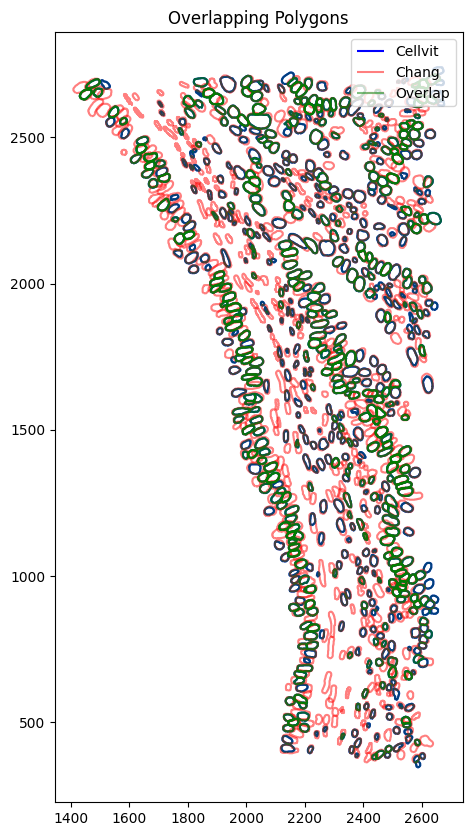

In [135]:
import geopandas as gpd
import matplotlib.pyplot as plt

file_path3 = '../data/processed/dataframe_cellvit_overlap_comparison.geojson'
gdf3 = gpd.read_file(file_path3)
gdf3.crs = None

# Perform a spatial join to find overlapping polygons
# 'inner' join will keep only overlapping polygons
overlap_gdf_cellvit = gpd.sjoin(gdf3, gdf2, how='inner', op='intersects')

# Print the resulting overlapping polygons
print(overlap_gdf_cellvit)

# Optionally, plot the overlapping polygons
fig, ax = plt.subplots(figsize=(10, 10))
gdf3.boundary.plot(ax=ax, color='blue', label='Cellvit')
gdf2.boundary.plot(ax=ax, color='red', alpha= 0.5,label='Chang')
overlap_gdf_cellvit.boundary.plot(ax=ax, color='green', alpha= 0.5, label='Overlap')
ax.set_title('Overlapping Polygons')
ax.legend()
plt.show()

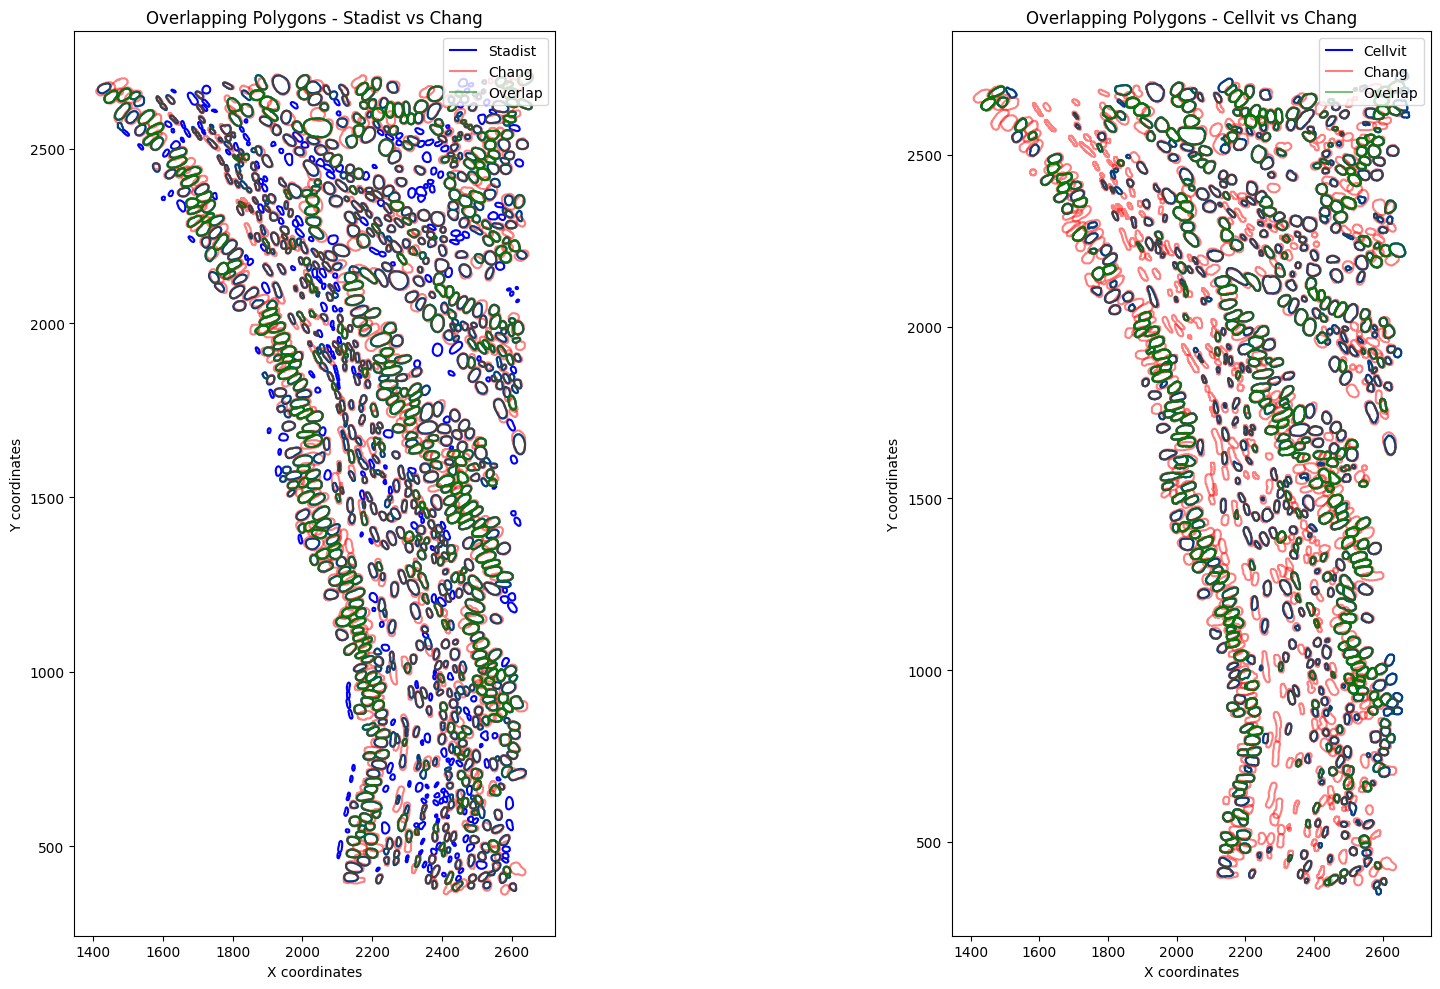

In [136]:
import matplotlib.pyplot as plt

# Create a figure with 2 subplots (side by side)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))

# Plot in the first subplot
gdf1.boundary.plot(ax=ax1, color='blue', label='Stadist')
gdf2.boundary.plot(ax=ax1, color='red', alpha=0.5, label='Chang')
overlap_gdf_stardist.boundary.plot(ax=ax1, color='green', alpha=0.5, label='Overlap')
ax1.set_title('Overlapping Polygons - Stadist vs Chang')
ax1.legend()
ax1.set_xlabel('X coordinates')
ax1.set_ylabel('Y coordinates')

# Plot in the second subplot
gdf3.boundary.plot(ax=ax2, color='blue', label='Cellvit')
gdf2.boundary.plot(ax=ax2, color='red', alpha=0.5, label='Chang')
overlap_gdf_cellvit.boundary.plot(ax=ax2, color='green', alpha=0.5, label='Overlap')
ax2.set_title('Overlapping Polygons - Cellvit vs Chang')
ax2.legend()
ax2.set_xlabel('X coordinates')
ax2.set_ylabel('Y coordinates')

# Adjust layout
plt.tight_layout()
plt.show()


                                               geometry  jaccard_index  \
0     POLYGON ((2249.222 552.000, 2248.906 554.169, ...       0.000000   
1     POLYGON ((2343.947 670.000, 2343.915 671.972, ...       0.000000   
2     POLYGON ((2166.516 572.000, 2165.213 575.026, ...       0.912131   
3     POLYGON ((2228.069 408.000, 2228.535 409.698, ...       0.758057   
4     POLYGON ((2247.061 486.000, 2247.278 487.448, ...       0.000248   
...                                                 ...            ...   
1215  POLYGON ((2551.750 2608.000, 2548.273 2609.646...       0.000000   
1216  POLYGON ((2499.431 2656.000, 2499.298 2657.452...       0.029305   
1217  POLYGON ((2582.975 2694.000, 2582.314 2698.041...       0.574551   
1218  POLYGON ((2523.576 2586.000, 2523.685 2587.529...       0.000000   
1219  POLYGON ((2524.573 2534.000, 2525.303 2537.840...       0.398752   

      dice_coefficient  
0             0.000000  
1             0.000000  
2             0.954047  
3          

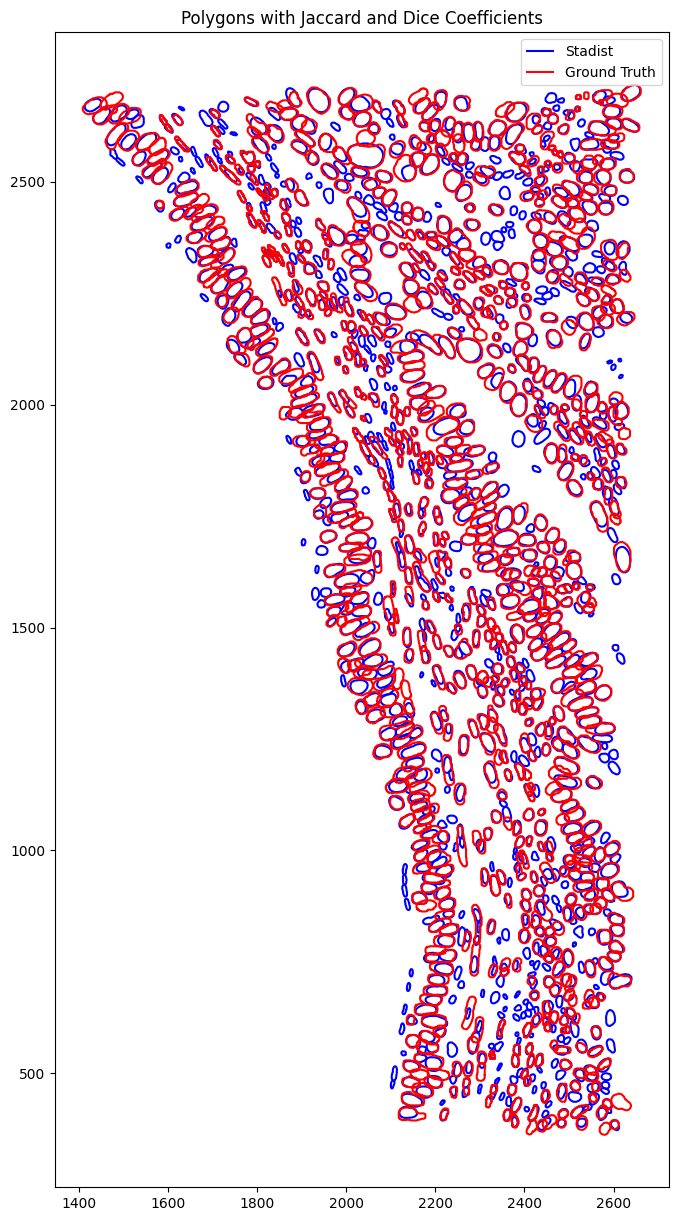

In [137]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon


# Initialize lists to store Jaccard and Dice coefficients
jaccard_indices = []
dice_coefficients = []

# Function to calculate Dice coefficient
def dice_coefficient(poly1, poly2):
    intersection_area = poly1.intersection(poly2).area
    dice_coeff = 2 * intersection_area / (poly1.area + poly2.area)
    return dice_coeff

# Iterate over each polygon in gdf1
for idx1, row1 in gdf1.iterrows():
    poly1 = row1['geometry']  # Polygon from gdf1

    # Initialize variables to store max coefficients and corresponding polygon in gdf2
    max_jaccard_index = 0
    max_jaccard_polygon = None
    max_dice_coeff = 0
    max_dice_polygon = None

    # Iterate over each polygon in gdf2 to find the maximum coefficients
    for idx2, row2 in gdf2.iterrows():
        poly2 = row2['geometry']  # Polygon from gdf2

        # Calculate Jaccard index
        intersection_area = poly1.intersection(poly2).area
        union_area = poly1.union(poly2).area
        if union_area > 0:
            jaccard_index = intersection_area / union_area
        else:
            jaccard_index = 0

        # Calculate Dice coefficient
        dice_coeff = dice_coefficient(poly1, poly2)

        # Update max Jaccard index and corresponding polygon in gdf2 if current is higher
        if jaccard_index > max_jaccard_index:
            max_jaccard_index = jaccard_index
            max_jaccard_polygon = poly2
        if dice_coeff > max_dice_coeff:
            max_dice_coeff = dice_coeff
            max_dice_polygon = poly2

    # Store the maximum coefficients found for the current polygon in gdf1
    jaccard_indices.append(max_jaccard_index)
    dice_coefficients.append(max_dice_coeff)

# Add Jaccard and Dice coefficients to gdf1 as new columns
gdf1['jaccard_index'] = jaccard_indices
gdf1['dice_coefficient'] = dice_coefficients

# Print the polygons in gdf1 with their corresponding coefficients
print(gdf1[['geometry', 'jaccard_index', 'dice_coefficient']])

# Save gdf1 with coefficients to a GeoJSON file
output_file = '../data/processed/overlap_coefficients.geojson'
gdf1.to_file(output_file, driver='GeoJSON')

# Optionally, plot the polygons in gdf1 and gdf2 with coefficients
fig, ax = plt.subplots(figsize=(10, 15))
gdf1.boundary.plot(ax=ax, color='blue', label='Stadist')
gdf2.boundary.plot(ax=ax, color='red', label='Ground Truth')
ax.set_title('Polygons with Jaccard and Dice Coefficients')
ax.legend()
plt.show()


In [138]:
print(gdf3.shape)
def is_valid(geom):
    return geom.is_valid

# Filter out invalid geometries
gdf3 = gdf3[gdf3['geometry'].apply(is_valid)]
print(gdf3.shape)

(692, 6)
(692, 6)


                                              geometry  jaccard_index  \
0    POLYGON ((2585.000 346.000, 2583.000 348.000, ...       0.018251   
1    POLYGON ((2577.000 362.000, 2576.000 363.000, ...       0.549231   
2    POLYGON ((2439.000 372.000, 2438.000 373.000, ...       0.435345   
3    POLYGON ((2603.000 374.000, 2595.000 382.000, ...       0.678195   
4    POLYGON ((2482.000 378.000, 2481.000 379.000, ...       0.815625   
..                                                 ...            ...   
687  POLYGON ((1964.000 2305.000, 1961.000 2308.000...       0.666027   
688  POLYGON ((2248.000 2316.000, 2242.000 2322.000...       0.535128   
689  POLYGON ((2165.000 2318.000, 2164.000 2319.000...       0.494662   
690  POLYGON ((1913.000 2344.000, 1910.000 2347.000...       0.754739   
691  POLYGON ((2148.000 2370.000, 2147.000 2371.000...       0.845802   

     dice_coefficient  
0            0.035848  
1            0.709037  
2            0.606607  
3            0.808244  
4  

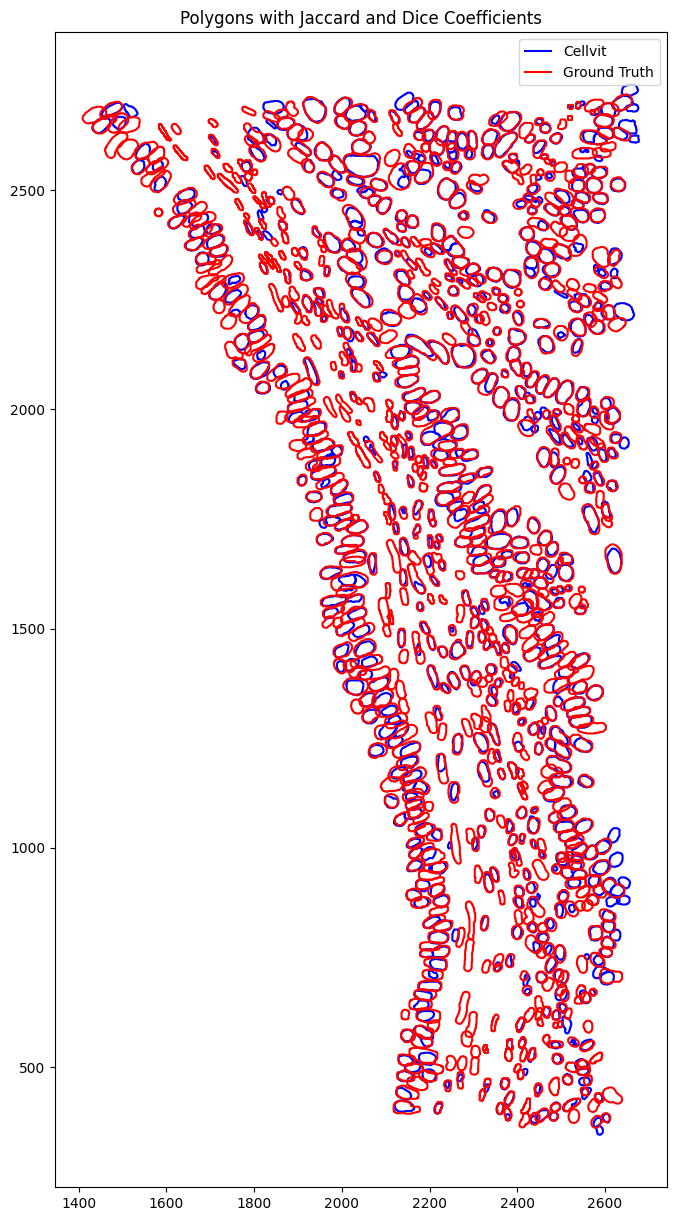

In [139]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon


# Initialize lists to store Jaccard and Dice coefficients
jaccard_indices = []
dice_coefficients = []

# Function to calculate Dice coefficient
def dice_coefficient(poly1, poly2):
    intersection_area = poly1.intersection(poly2).area
    dice_coeff = 2 * intersection_area / (poly1.area + poly2.area)
    return dice_coeff

# Iterate over each polygon in gdf1
for idx1, row1 in gdf3.iterrows():
    poly1 = row1['geometry']  # Polygon from gdf1

    # Initialize variables to store max coefficients and corresponding polygon in gdf2
    max_jaccard_index = 0
    max_jaccard_polygon = None
    max_dice_coeff = 0
    max_dice_polygon = None

    # Iterate over each polygon in gdf2 to find the maximum coefficients
    for idx2, row2 in gdf2.iterrows():
        poly2 = row2['geometry']  # Polygon from gdf2

        # Calculate Jaccard index
        intersection_area = poly1.intersection(poly2).area
        union_area = poly1.union(poly2).area
        if union_area > 0:
            jaccard_index = intersection_area / union_area
        else:
            jaccard_index = 0

        # Calculate Dice coefficient
        dice_coeff = dice_coefficient(poly1, poly2)

        # Update max Jaccard index and corresponding polygon in gdf2 if current is higher
        if jaccard_index > max_jaccard_index:
            max_jaccard_index = jaccard_index
            max_jaccard_polygon = poly2
        if dice_coeff > max_dice_coeff:
            max_dice_coeff = dice_coeff
            max_dice_polygon = poly2

    # Store the maximum coefficients found for the current polygon in gdf1
    jaccard_indices.append(max_jaccard_index)
    dice_coefficients.append(max_dice_coeff)

# Add Jaccard and Dice coefficients to gdf1 as new columns
gdf3['jaccard_index'] = jaccard_indices
gdf3['dice_coefficient'] = dice_coefficients

# Print the polygons in gdf1 with their corresponding coefficients
print(gdf3[['geometry', 'jaccard_index', 'dice_coefficient']])

# Save gdf1 with coefficients to a GeoJSON file
output_file = '../data/processed/overlap_coefficients_cellvit.geojson'
gdf3.to_file(output_file, driver='GeoJSON')

# Optionally, plot the polygons in gdf1 and gdf2 with coefficients
fig, ax = plt.subplots(figsize=(10, 15))
gdf3.boundary.plot(ax=ax, color='blue', label='Cellvit')
gdf2.boundary.plot(ax=ax, color='red', label='Ground Truth')
ax.set_title('Polygons with Jaccard and Dice Coefficients')
ax.legend()
plt.show()


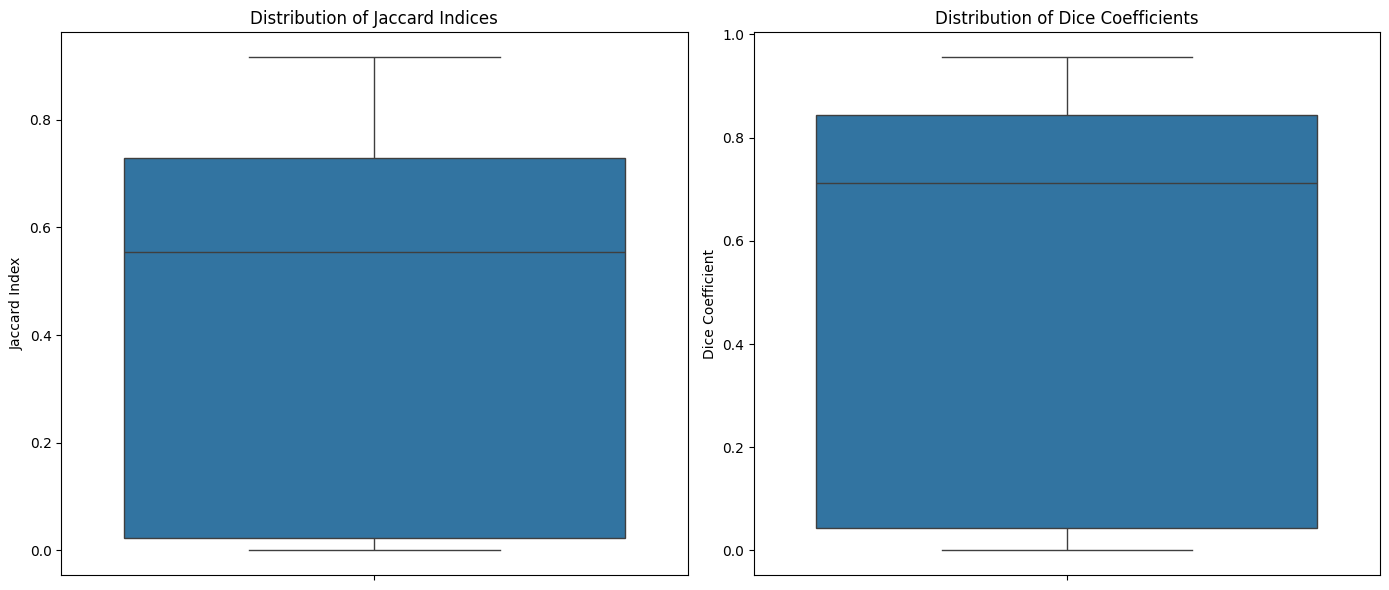

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Boxplot for Jaccard indices
sns.boxplot(data=gdf1['jaccard_index'], orient='v', ax=ax1)
ax1.set_title('Distribution of Jaccard Indices')
ax1.set_ylabel('Jaccard Index')

# Boxplot for Dice coefficients
sns.boxplot(data=gdf1['dice_coefficient'], orient='v', ax=ax2)
ax2.set_title('Distribution of Dice Coefficients')
ax2.set_ylabel('Dice Coefficient')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


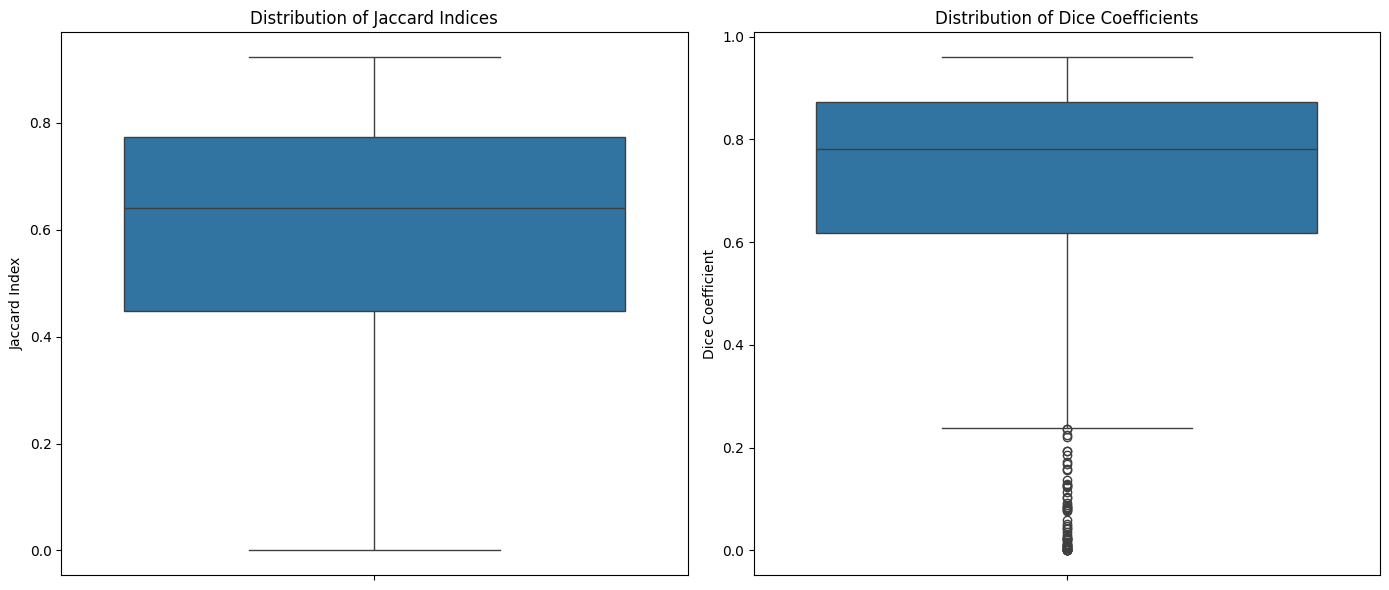

In [141]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Boxplot for Jaccard indices
sns.boxplot(data=gdf3['jaccard_index'], orient='v', ax=ax1)
ax1.set_title('Distribution of Jaccard Indices')
ax1.set_ylabel('Jaccard Index')

# Boxplot for Dice coefficients
sns.boxplot(data=gdf3['dice_coefficient'], orient='v', ax=ax2)
ax2.set_title('Distribution of Dice Coefficients')
ax2.set_ylabel('Dice Coefficient')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


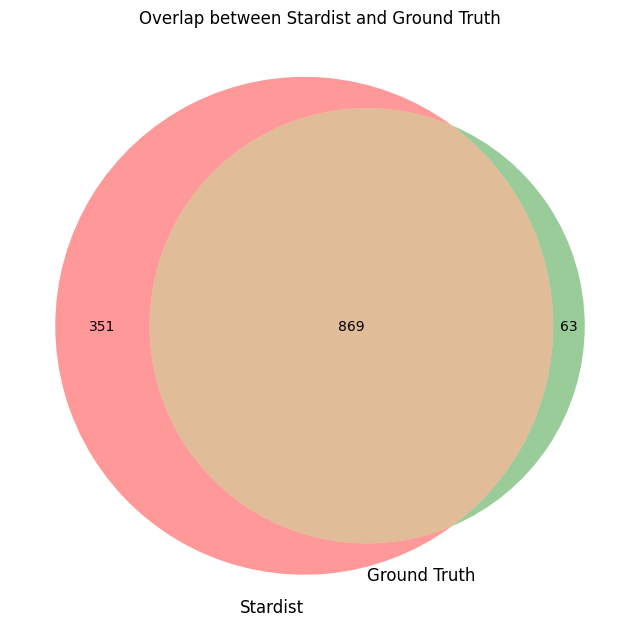

In [142]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Calculate the intersection area and the original area
overlap_gdf_stardist['intersection_area'] = overlap_gdf_stardist.apply(
    lambda row: row['geometry'].intersection(gdf2.loc[row['index_right'], 'geometry']).area, axis=1)
overlap_gdf_stardist['original_area'] = overlap_gdf_stardist['geometry'].area

# Filter for more than 50% overlap
overlap_gdf_05 = overlap_gdf_stardist[overlap_gdf_stardist['intersection_area'] / overlap_gdf_stardist['original_area'] > 0.5]

# Calculate number of unique overlaps
gdf1_non_overlap = len(gdf1) - len(overlap_gdf_05)
gdf2_non_overlap = len(gdf2) - len(overlap_gdf_05)
overlap_count = len(overlap_gdf_05)

# Plot Venn diagram
plt.figure(figsize=(8, 8))
venn2(subsets=(gdf1_non_overlap, gdf2_non_overlap, overlap_count),
      set_labels=('Stardist', 'Ground Truth'))
plt.title('Overlap between Stardist and Ground Truth')
plt.show()


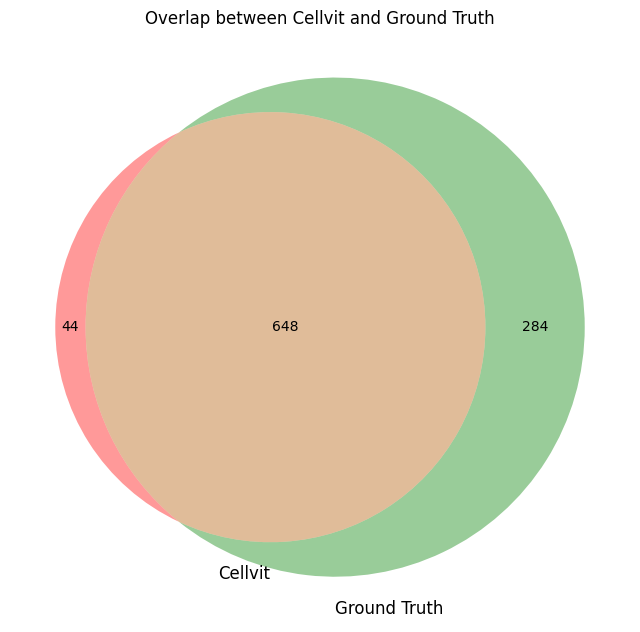

In [143]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Calculate the intersection area and the original area
overlap_gdf_cellvit['intersection_area'] = overlap_gdf_cellvit.apply(
    lambda row: row['geometry'].intersection(gdf2.loc[row['index_right'], 'geometry']).area, axis=1)

overlap_gdf_cellvit['original_area'] = overlap_gdf_cellvit['geometry'].area

# Filter for more than 50% overlap
overlap_gdf_05 = overlap_gdf_cellvit[overlap_gdf_cellvit['intersection_area'] / overlap_gdf_cellvit['original_area'] > 0.5]

# Calculate number of unique overlaps
gdf3_non_overlap = len(gdf3) - len(overlap_gdf_05.geometry)
gdf2_non_overlap = len(gdf2) - len(overlap_gdf_05.geometry)
overlap_count = len(overlap_gdf_05.geometry)

# Plot Venn diagram
plt.figure(figsize=(8, 8))
venn2(subsets=(gdf3_non_overlap, gdf2_non_overlap, overlap_count),
      set_labels=('Cellvit', 'Ground Truth'))
plt.title('Overlap between Cellvit and Ground Truth')
plt.show()
